# Essai de détermination des réformes possibles à partir de l'étude d'impact

On commence par initialiser le simulateur et importer des bibliothèques utiles.

In [1]:
from retraites.SimulateurRetraites import SimulateurRetraites
import pylab as pl
from scipy import interpolate
from copy import deepcopy
import numpy as np

## Détermination de la trajectoire des dépenses


In [2]:
def calculDepensesEtudeImpact():
    simulateur = SimulateurRetraites('../retraites/fileProjection.json')
    analyse = simulateur.pilotageCOR()
    s=2
    analyse.scenarios=[s] # on se concentre sur le scenario 1,3% croissance

    annees_constatees = []
    depenses_constatees = []
    for a in simulateur.annees:
        if (a<2021):
            annees_constatees.append(a)
            depenses_constatees.append(analyse.Depenses[s][a])

    premiere_annee_constatee = annees_constatees[0]

    derniere_depense_constatee = depenses_constatees[-1]

    annees = [2020,                         2025,  2030,  2040,  2050,  2060,  2070]
    depenses = [derniere_depense_constatee, 0.136, 0.135, 0.133, 0.129, 0.127, 0.126]
    nb_annees = len(annees)

    depenses_interpolateur = interpolate.interp1d(annees, depenses, kind="quadratic")

    depenses_EI = deepcopy(analyse.Depenses)
    for a in simulateur.annees_futures:
        if (a>=2020):
            depenses_EI[s][a] = depenses_interpolateur(a)
    
    return depenses_EI

In [3]:
depenses_EI = calculDepensesEtudeImpact()

In [4]:
s=2
scenarios=[s] # on se concentre sur le scenario 1,3% croissance

In [5]:
simulateur = SimulateurRetraites('../retraites/fileProjection.json')
analyse = simulateur.pilotageCOR()

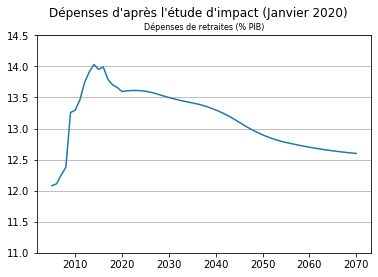

In [6]:
pl.suptitle("Dépenses d'après l'étude d'impact (Janvier 2020)");
analyse.graphique(depenses_EI,"Depenses", scenarios_indices = scenarios)
pl.grid(axis="y")
pl.ylim(bottom=11.0, top=14.5);

## Calcul de la trajectoire des âges de départ en retraite de l'étude d'impact

In [7]:
def calculeAgeDepartRetraiteEtudeImpact():
    """
    Calcule l'âge de départ en retraite de l'étude d'impact (Janvier 2020).
    """
    premiere_generation = 1975
    age_premiere_generation = 63.8
    derniere_generation = 1990
    age_derniere_generation = 64.83
    annee_transition = int(premiere_generation + age_premiere_generation)

    def ageDepart(a):
        Age1 = age_premiere_generation
        Age2 = age_derniere_generation
        a1 = premiere_generation
        a2 = derniere_generation
        As = (Age2 * (a - a1) + Age1 * (a2 - a)) / ((a2 - a1) + (Age2 - Age1))
        return As

    simulateur = SimulateurRetraites('../retraites/fileProjection.json')
    analyse = simulateur.pilotageCOR()

    annees_constatees = []
    Age_COR = []
    s = 1 # Premier scénario
    for a in simulateur.annees:
        if (a<=annee_transition):
            annees_constatees.append(a)
            Age_COR.append(analyse.A[s][a])

    annees_table_EI = range(annee_transition,2051)
    Age_table_EI = [ageDepart(a) for a in annees_table_EI]

    annees_table_extrapolation = range(2050,2070)
    Age_table_extrapolation = [ageDepart(a) for a in annees_table_extrapolation]

    As = deepcopy(simulateur.A)
    for s in simulateur.scenarios:
        for a in simulateur.annees_futures:
            if (a>=annee_transition):
                As[s][a] = ageDepart(a)
                
    return As

In [8]:
As_EI = calculeAgeDepartRetraiteEtudeImpact()

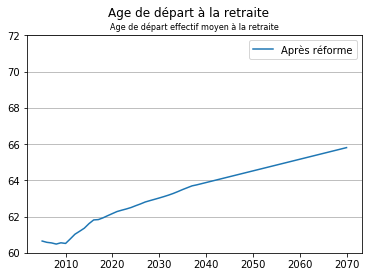

In [9]:
pl.suptitle("Age de départ à la retraite");
analyse.graphique(As_EI,"A",scenarios_indices=[1])
pl.legend(["Après réforme"])
pl.grid(axis="y")

## Calcul de la trajectoire de solde financier

Nous commençons par extraire les soldes constatés jusqu'à 2020 dans les données du COR.

In [10]:
def calculeSoldeEtudeImpact():
    """
    Calcul le solde de l'étude d'impact (Janvier 2020).
    """
    simulateur = SimulateurRetraites('../retraites/fileProjection.json')
    analyse = simulateur.pilotageCOR()

    annees_constatees = []
    soldes_constatees = []
    s = 1 # Premier scénario
    for a in simulateur.annees:
        if (a<2021):
            annees_constatees.append(a)
            soldes_constatees.append(analyse.S[s][a])

    dernier_solde_constate = soldes_constatees[-1]

    annees = [2020, 2027, 2070]
    soldes = [dernier_solde_constate, 0.0, 0.0]

    soldes_interpolateur = interpolate.interp1d(annees, soldes)

    annees_table_EI = range(2020,2051)
    soldes_table_EI = soldes_interpolateur(annees_table_EI)

    annees_table_extrapolation = range(2050,2070)
    soldes_table_extrapolation = soldes_interpolateur(annees_table_extrapolation)

    soldes_EI = deepcopy(analyse.S)
    for s in simulateur.scenarios:
        for a in simulateur.annees_futures:
            if (a>=2020):
                soldes_EI[s][a] = soldes_interpolateur(a)
    
    return soldes_EI

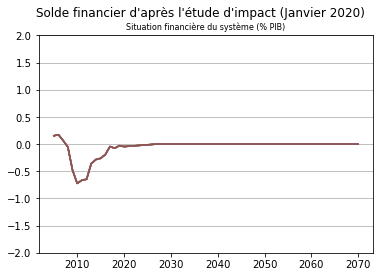

In [11]:
soldes_EI = calculeSoldeEtudeImpact()
pl.suptitle("Solde financier d'après l'étude d'impact (Janvier 2020)");
analyse.graphique(soldes_EI,"S")
pl.grid(axis="y")

## Calcul des couples (ages, pensions)

In [12]:
Acible=deepcopy(analyse.A)

En faisant une interpolation entre un départ à 62 ans et l'âge calculé plus haut, on balaye les possibilités de réalisations (toujours sous la contrainte système équilibré et taux de cotisation) et on trace l'évolution des courbes ages-pension en fonction des années.

In [13]:
annees = [2020, 2025, 2030, 2040, 2050, 2060, 2070]
lx = [ [] for i in range(len(annees)) ]
ly = [ [] for i in range(len(annees)) ]

for x in pl.arange(0.0,1.001,0.01):

    for a in simulateur.annees_futures:
        Acible[s][a] = 62.0*(1-x) + 70.0*x
    
    analyse = simulateur.pilotageParAgeEtDepenses(Acible=Acible, Dcible=depenses_EI, Scible=0.0)
    
    for i in range(len(annees)):
        lx[i].append( analyse.A[s][annees[i]] )
        ly[i].append( analyse.P[s][annees[i]] )

## Comparaison de l'étude d'impact avec tous les couples possibles

In [14]:
analyse = simulateur.pilotageParAgeEtDepenses(Acible=As_EI, Dcible=depenses_EI, Scible=soldes_EI)

In [15]:
pensions_EI = []
ages_EI = []
for a in simulateur.annees_futures:
    ages_EI.append(As_EI[s][a])
    pensions_EI.append(analyse.P[s][a])

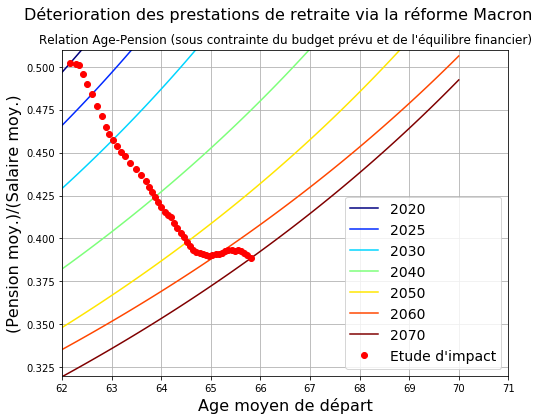

In [16]:
# pour avoir une jolie grille
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
major_ticks = pl.arange(62, 73, 1)
ax.set_xticks(major_ticks)
pl.grid()

colors = pl.cm.jet(pl.linspace(0,1,len(annees)))

pl.suptitle("Déterioration des prestations de retraite via la réforme Macron",fontsize=16)
pl.title("Relation Age-Pension (sous contrainte du budget prévu et de l'équilibre financier)")
pl.xlabel("Age moyen de départ",fontsize=16)
pl.ylabel("(Pension moy.)/(Salaire moy.)",fontsize=16)
pl.xlim(62.0, 71.0)
pl.ylim(0.32,0.51)

# trace les courbes
for i in range(len(annees)):
    pl.plot(lx[i],ly[i], label=str(annees[i]), color=colors[i])

pl.plot(ages_EI,pensions_EI,"ro", label="Etude d'impact")

pl.legend(fontsize=14);

pl.savefig("Article4/Simulation-Age-vs-pensions-vs-date.png")
pl.savefig("Article4/Simulation-Age-vs-pensions-vs-date.pdf")

En haut à gauche du graphique, c'est la pension rêvée du point de point de vue individuel: départ tôt et pension élevée. En bas à droite, c'est la pensée cauchemar.
En 2020, on a une pension rêvée. Avec le temps, les contraintes budgétaires choisies par le gouvernement font baisser la courbe age-pension vers le coin cauchemardesque.